In [1]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad, functional
import scipy.io
import seaborn as sns
from matplotlib.colors import ListedColormap

## Model parameters

In [2]:
# The number of snapshots for the forward-backward process
batch_time = 20
batch_size = 100
adjoint = False
gpu = 0 # Check if one GPU exists
niters = 5000
test_freq = 20
coarse_deg = 16

In [3]:
# Determines what solver to use
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    # This is the default
    from torchdiffeq import odeint

# Check if there are gpus
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

# Define zero
t_zero = torch.FloatTensor([0])

In [4]:
# This is the class that contains the NN that estimates the RHS
class ODEFunc(nn.Module):
    def __init__(self,N):
        super(ODEFunc, self).__init__()
        # Change the NN architecture here
        self.net = nn.Sequential(
            nn.Linear(N, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200,200),
            nn.ReLU(),
            nn.Linear(200, N),
        )

        self.lin=nn.Sequential(nn.Linear(N, N,bias=False),)

        for m in self.lin.modules():
            if isinstance(m, nn.Linear):
                m.weight=nn.Parameter(torch.from_numpy(self.Linear(N)).float())
                m.weight.requires_grad=False


    def forward(self, t, y):
        return self.lin(y) + self.net(y)
    
    def Linear(self,N):
        alpha = 8.0e-4
        dx2=np.zeros((N,N))
        for i in range(N):

            dx2[i,i]=-2
            if i==0:
                dx2[i,-1]=1
                dx2[i,i+1]=1
            elif i==N-1:
                dx2[i,i-1]=1
                dx2[i,0]=1       
            else:
                dx2[i,i-1]=1
                dx2[i,i+1]=1

        dx=1/N
        A=alpha*(1/dx**2)*dx2

        return A
    
    
# This class is used for updating the gradient
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [5]:
# Gets a batch of y from the data evolved forward in time (default 20)
def get_batch(ttorch,utorch):
    [IC,length,_]=utorch.shape

    x=[[j,i] for i in range(length-batch_time) for j in range(IC)]
    lis=[x[i] for i in np.random.choice(len(x),batch_size,replace=False)]

    for i in range(len(lis)):
        if i==0:
            batch_y0=utorch[lis[i][0],lis[i][1]][None,:]
            batch_t = ttorch[lis[i][0],lis[i][1]:lis[i][1]+batch_time][None,:]-ttorch[lis[i][0],lis[i][1]][None,None]
            batch_y = torch.stack([utorch[lis[i][0],lis[i][1]+j] for j in range(batch_time)], dim=0)[:,None,:]
        else:
            batch_y0=torch.cat((batch_y0,utorch[lis[i][0],lis[i][1]][None,:]))
            batch_t=torch.cat((batch_t,ttorch[lis[i][0],lis[i][1]:lis[i][1]+batch_time][None,:]-ttorch[lis[i][0],lis[i][1]][None,None]))
            batch_y=torch.cat((batch_y,torch.stack([utorch[lis[i][0],lis[i][1]+j] for j in range(batch_time)], dim=0)[:,None,:]),axis=1)

    return batch_y0, batch_t, batch_y

In [6]:
# Plotting scripts
def plotting(true_y, pred_y,xlabel='x',ylabel='y',zlabel='z'):
    plt.figure(figsize=(7.5,6))
    ax=plt.subplot(projection='3d')
    #ax.set_xlim([-25,25])
    #ax.set_ylim([-25,25])
    #ax.set_zlim([0,40])
    plt.plot(true_y.detach().numpy()[:, 0, 0],true_y.detach().numpy()[:, 0, 1],true_y.detach().numpy()[:, 0, 2],'.',color='black',linewidth=.5,markersize=1,alpha=1)
    plt.plot(pred_y.detach().numpy()[:, 0, 0],pred_y.detach().numpy()[:, 0, 1],pred_y.detach().numpy()[:, 0, 2],'.',color='red',linewidth=.5,markersize=1,alpha=.6)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.legend(('True','Pred'))
    
def plot2d(u_true,u_pred):
    N=u_true.shape[0]
    colors=sns.diverging_palette(240, 10, n=9,as_cmap=True)

    col=3
    row=3
    scale=1.2
    fig, axs = plt.subplots(col, row, sharex='col', sharey='row',figsize=(scale*col,scale*row))

    for i in range(col):
        for j in range(row):
            T=10*(i*col+j)
            axs[i][j].plot( np.linspace(0,1,N), u_true[:,T])
            axs[i][j].plot( np.linspace(0,1,N), u_pred[:,T],'--')
            #axs[i][j].legend((r'$u$'+str(T),r'$\tilde{u}$'+str(T)))

def plot_trajectories(t_true,u_true,t_pred,u_pred):
    N=u_true.shape[0]

    colors=sns.diverging_palette(240, 10, n=9,as_cmap=True)
    colors2=sns.diverging_palette(240, 10, n=41)
    colors2 = ListedColormap(colors2[20:])
    fig, axs = plt.subplots(3, 1, sharex='col', sharey='row',figsize=(4,4))
    (ax1),(ax2),(ax3) = axs
    im=ax1.pcolormesh(t_true, np.linspace(0,2*np.pi,N), u_true, shading='gouraud', cmap=colors,vmin=-1,vmax=1)
    im2=ax2.pcolormesh(t_pred, np.linspace(0,2*np.pi,N), u_pred, shading='gouraud', cmap=colors,vmin=-1,vmax=1)
    im3=ax3.pcolormesh(t_pred, np.linspace(0,2*np.pi,N), np.abs(u_pred-u_true), shading='gouraud', cmap=colors2,vmin=0,vmax=1)
    
    ax1.set(ylabel='x')
    ax2.set(ylabel='x')  
    ax3.set(ylabel='x')
    ax3.set(xlabel='t')
    
    cax = fig.add_axes([.91, 0.6575, 0.015, 0.225]) #left bottom width height
    cb=fig.colorbar(im, cax=cax, orientation='vertical')
    cb.set_label(r'$u$')
    cax2 = fig.add_axes([.91, 0.39, 0.015, 0.225]) #left bottom width height
    cb2=fig.colorbar(im2, cax=cax2, orientation='vertical')
    cb2.set_label(r'$u_{NN}$')
    cax3 = fig.add_axes([.91, 0.124, 0.015, 0.222]) #left bottom width height
    cb3=fig.colorbar(im3, cax=cax3, orientation='vertical')
    cb3.set_label(r'$|u-u_{NN}|$')
    
    for ax in axs.flat:
        ax.label_outer()

In [7]:
# Import Data
[u,t]=pickle.load(open('/home/rmlans/Desktop/Research/di_sciml/code/neural_ode/Data_T5_IC1000.p','rb'))
u = np.asarray(u)
u = u[:,:,::coarse_deg]

utorch=torch.Tensor(u)
utorch=utorch.type(torch.FloatTensor)
[IC,T,N]=utorch.shape
ttorch=torch.Tensor(t)
ttorch=ttorch.type(torch.FloatTensor)


###########################################################################
# Initialize NN for learning the RHS and setup optimization parms
###########################################################################
func = ODEFunc(N)
optimizer = optim.Adam(func.parameters(), lr=1e-4) #optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(niters/3), gamma=0.1)
end = time.time()
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

err=[]
test_err=[]
ii = 0
###########################################################################
# Optimization iterations
###########################################################################
ex=0
for itr in range(1, niters + 1):

    # Get the batch and initialzie the optimizer
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(ttorch,utorch)

    batch_t=batch_t[0]

    if itr==1:
        print('Batch Time Units: '+str(batch_t.detach().numpy()[-1])+'\n')

    # Make a prediction and calculate the loss
    pred_y = odeint(func, batch_y0, batch_t)

    loss = torch.mean(torch.abs(pred_y - batch_y)) # Compute the mean (because this includes the IC it is not as high as it should be)

    loss.backward() #Computes the gradient of the loss (w.r.t to the parameters of the network)
    # Use the optimizer to update the model
    optimizer.step()
    scheduler.step()

    # Print out the Loss and the time the computation took
    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())
    if itr % test_freq == 0:
        with torch.no_grad():
            # Testing loss
            # batch_y0, batch_t, batch_y = get_batch(test_t,test_y)
            # pred_y = odeint(func, batch_y0, batch_t)
            # test_loss = torch.mean(torch.abs(pred_y - batch_y))

            err.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f} | Time {:.6f}'.format(itr, loss.item(),time.time() - end)+'\n')
            ii += 1
            
            torch.save(func, 'model.pt')
    end = time.time()

###########################################################################
# Plot results and save the model
###########################################################################
torch.save(func, 'model.pt')

# Plot the learning
plt.figure()
plt.plot(np.arange(test_freq,niters+1,test_freq),np.asarray(err),'-')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

Batch Time Units: 0.95000005

Iter 0020 | Total Loss 0.026165 | Time 0.299897

Iter 0040 | Total Loss 0.025157 | Time 0.284980

Iter 0060 | Total Loss 0.022357 | Time 0.237762

Iter 0080 | Total Loss 0.018500 | Time 0.308122

Iter 0100 | Total Loss 0.020751 | Time 0.227724

Iter 0120 | Total Loss 0.014747 | Time 0.282845

Iter 0140 | Total Loss 0.019163 | Time 0.251158

Iter 0160 | Total Loss 0.016699 | Time 0.340076

Iter 0180 | Total Loss 0.013592 | Time 0.296292

Iter 0200 | Total Loss 0.014110 | Time 0.384957

Iter 0220 | Total Loss 0.019250 | Time 0.459268

Iter 0240 | Total Loss 0.015236 | Time 0.499340

Iter 0260 | Total Loss 0.014085 | Time 0.413773

Iter 0280 | Total Loss 0.016372 | Time 0.699967

Iter 0300 | Total Loss 0.013526 | Time 0.443482

Iter 0320 | Total Loss 0.014839 | Time 0.373873

Iter 0340 | Total Loss 0.017284 | Time 0.416990

Iter 0360 | Total Loss 0.017289 | Time 0.461132

Iter 0380 | Total Loss 0.015342 | Time 0.421204

Iter 0400 | Total Loss 0.018729 | Time 

KeyboardInterrupt: 

## Testing

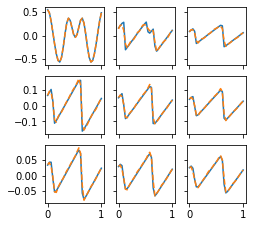

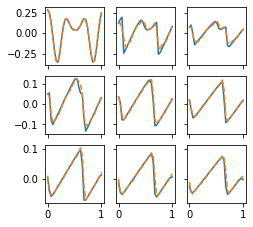

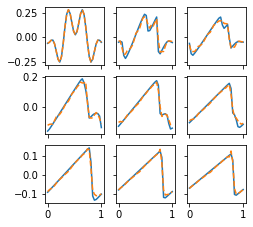

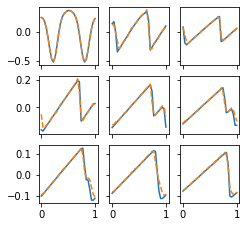

In [8]:
[u,t]=pickle.load(open('/home/rmlans/Desktop/Research/di_sciml/code/neural_ode/Data_T5_IC100.p','rb'))
u = np.asarray(u)
u = u[:,:,::coarse_deg]

utorch=torch.Tensor(u)
utorch=utorch.type(torch.FloatTensor)
[IC,T,N]=utorch.shape
ttorch=torch.Tensor(t)
ttorch=ttorch.type(torch.FloatTensor)

# LES testing
func = torch.load('model_pretrained.pt')
for ex in range(4): # Change this for all ICs
    pred_y = odeint(func, utorch[ex,0,:], ttorch[ex,:])

#     plot_trajectories(t[ex],u[ex].transpose(),t[ex],pred_y.detach().numpy().transpose())
#     plt.savefig('Predicted_Traj_'+str(ex)+'.png')

    plot2d(u[ex].transpose(),pred_y.detach().numpy().transpose())
    plt.show()
#     plt.savefig('Predicted_Traj2D_'+str(ex)+'.png')